# Simulated base inference of SEEG signals using 2D VEP model

### This notebook estimates and analyzes the heterogeneity of Z to find the optimal value of Z in order to fix its value for later simulations.

We have already found the optimal values of x and tau in the previous notebooks. Find x here https://colab.research.google.com/drive/10FtsyNbK2i5UTE8EN5I6Gw2EhtdaQcxE and tau here https://colab.research.google.com/drive/1DJ-Yt63FpQTx9O6Nkv0j3sUwKXn0H7wB#scrollTo=rjxwz0uetz1Z

Process:
1. Prior
2. Sample from prior
3. Simulate using sample
4. Train simulation
5. Prosterio sampling result from training
6. Observe

In [ ]:
import os
os.environ["TORCH_DISABLE_DYNAMO"] = "1"

import time
import errno
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

First install SBI and clone repo and make sure everything is compatiable

In [ ]:
!git clone https://github.com/ins-amu/BVEP.git

Cloning into 'BVEP'...
remote: Enumerating objects: 3211, done.
remote: Counting objects: 100% (2643/2643), done.
remote: Compressing objects: 100% (1376/1376), done.
remote: Total 3211 (delta 1284), reused 2579 (delta 1234), pack-reused 568 (from 1)
Receiving objects: 100% (3211/3211), 151.91 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (1557/1557), done.
Updating files: 100% (3913/3913), done.


In [ ]:
!pip install sbi==0.24.0 torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.1/383.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━

In [ ]:
import sbi
import torch

In [ ]:
# sbi workflow:
# 1. Define simulator
# 2. Wrap simulater
# 3. Generate simulations
# 4. Use SNPE inference method
# 5. Train, then sample posterior

from sbi.inference import SNPE #See paper on (Training deep neural density estimators to identify mechanistic models of neural dynamics)
from sbi.simulators import linear_gaussian
from sbi.utils import BoxUniform
import sbi.utils as utils
from sbi.analysis import pairplot

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

To get access to the Github repo BVEP

In [ ]:
import sys
sys.path.append('/content/BVEP/SBI')

In [ ]:
from BVEP_SME import SME_labels, SEM_violinplot, plot_zscore_shrinkage, true_node_binary, estimated_node_binary, SME_accuracy

In [ ]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Check versions
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v2.0.2
Running on torch: v2.5.1+cu124
Running on sbi: v0.24.0


In [ ]:
#We will store our results in this directory
Res_dir='Res_BVEP_ode_sbi_maf_sourcelevel_onset_patient1_savesim_v18_samplerejection'

### Constants

In [ ]:
I1=3.1
eta_c=-2.05
delta_eta=1.0
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [ ]:
# Set cwd to the directory containing the data
cwd = '/content/BVEP/SBI'
cwd

'/content/BVEP/SBI'

## Structural Connectivity and Gain Matrices

In [ ]:
weights_path = os.path.join('/content/BVEP/Optimization/sacess_VEP_models/benchmarks/python/ExperimentalData/connectivity', 'weights.txt')
weights = np.loadtxt(weights_path)

In [ ]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [ ]:
weights.min(), weights.max()

(np.float64(0.0), np.float64(1.0))

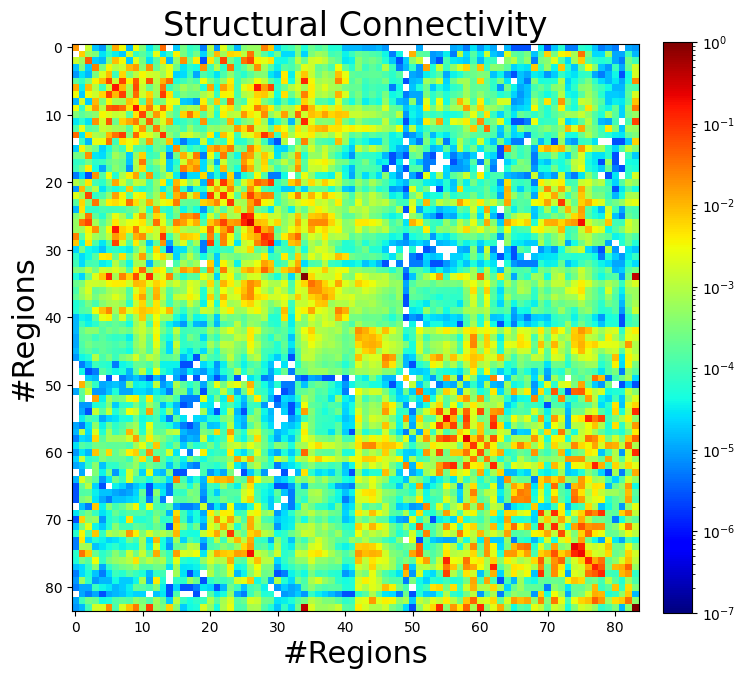

In [ ]:
Res_dir = 'results'

results_path = os.path.join(cwd, Res_dir)
os.makedirs(results_path, exist_ok=True)

plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights, norm=norm, cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Structural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.savefig(os.path.join(results_path, "SCMatrix.png"), dpi=800)
plt.savefig(os.path.join(results_path, "SCMatrix.svg"), dpi=800)
plt.show()


Structural Connectivity Matrix

This is the connectivity between the brain regions (n regions) from tractography technique.

The stronger the connection, the more dense it is. The density is represented here by the red color. The red area is within the hemisphere. The yellow area is the between of the hempsihere.

It is symmetric.

## ROIs chosen as Epileptogenic/propagation zones

EZ: epileptogenic zone;
PZ: propagation zone;
HZ: healthy zone;

In [ ]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [ ]:
#Here, confidential medical information
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

#Here we increased the connection between the regions to easier get the propgation from ez to pz (red to yellow)
#There are not true values

weights[np.diag_indices(weights.shape[0])] = 0

In [ ]:
SC=weights #the SC is based on the weights
SC.shape

(84, 84)

### Simulator

Redefined the VEP2D model to estimate Z as our parameter rather than eta, modified helper functions accordingly.

In [ ]:
@jit(nopython=True)
def epileptor2D_sde_fn_z(y, dt, sigma,  eta, tau, K, SC):
    eta = np.asarray(eta, dtype=np.float64) #we must add this to fix eta
    nn = SC.shape[0]
    x = y[0:nn]
    z = y[nn:2*nn]
    I1 = 3.1
    gx = np.sum(K * SC * (np.expand_dims(x, axis=0) - np.expand_dims(x, axis=1)), axis=1)
    dx = 1.0 - np.power(x, 3) - 2 * np.power(x, 2) - z + I1 + np.sqrt(dt)*sigma*np.random.randn()
    dz = (1.0/tau)*(4*(x - eta) - z - gx) + np.sqrt(dt)*sigma*np.random.randn()
    return np.concatenate((dx, dz))

In [ ]:
@jit(nopython=True)
def Integrator_Euler_Z(y_init, nt, dt, sigma, eta, tau, K, SC):
    nn = SC.shape[0]
    y_out = np.zeros((2*nn, nt))
    y_next = y_init
    h = dt
    for i in np.arange(nt):
            k1 = epileptor2D_sde_fn_z(y_next, dt, sigma, eta, tau, K, SC)
            y_next = y_next + (h) * (k1)
            y_out[:,i] =  y_next
    return y_out

In [ ]:
#new VEP2Dmodel to estimate z
@jit(nopython=True)
def VEP2Dmodel(params, constants, init_conditions, dt, ts, SC):
    nt=ts.shape[0]
    nn=SC.shape[0]

    #parameters
    z=params[0:nn]
    K=params[-1]

    # fixed parameters, tau eta and sigma
    eta = constants[0]
    sigma=constants[1]

    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0]*np.ones(nn), init_conditions[1]*np.ones(nn)

    y_init =np.concatenate((x_init, z_init), axis=0)

    y_euler = Integrator_Euler_Z(y_init, nt, dt, sigma, eta, tau, K, SC)

    x=y_euler[0:nn,]
    z=y_euler[nn:2*nn,]

    return x.reshape(-1)


### Some simulations for  sanity check

In [ ]:
T = 14.0 #We fixed tau so we are going to fix T too
dt=0.1
ts = np.arange(0, T + dt, dt)

In [ ]:
nt=ts.shape[0]
nt

141

In [ ]:
nn=SC.shape[0] #so here nn is defined as 84 based on the SC
nn

84

In [ ]:
ns=nn
ns
#ns is the number of sensors

84

In [ ]:
tau=10.
sigma=0*10e-1


In [ ]:
#define eta as the constant
eta = np.ones(nn)*hz_val #Eta is defined as a spatial map
eta[ez_idx] = ez_val
eta[pz_idx] = pz_val
sigma=0*10e-1


In [ ]:
constants = (eta, sigma)
constants

(array([-3.65, -3.65, -3.65, -3.65, -3.65, -2.4 , -1.6 , -3.65, -3.65,
        -3.65, -3.65, -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -1.6 , -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
        -3.65, -3.65, -3.65]),
 0.0)

In [ ]:
K_true=1.0

In [ ]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [ ]:
#Must define z_true as the param
z_true = 3.5

In [ ]:
params_true = np.append(z_true, K_true)
params_true.shape

(2,)

In [ ]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 8.598293781280518


In [ ]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.00409388542175293


In [ ]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

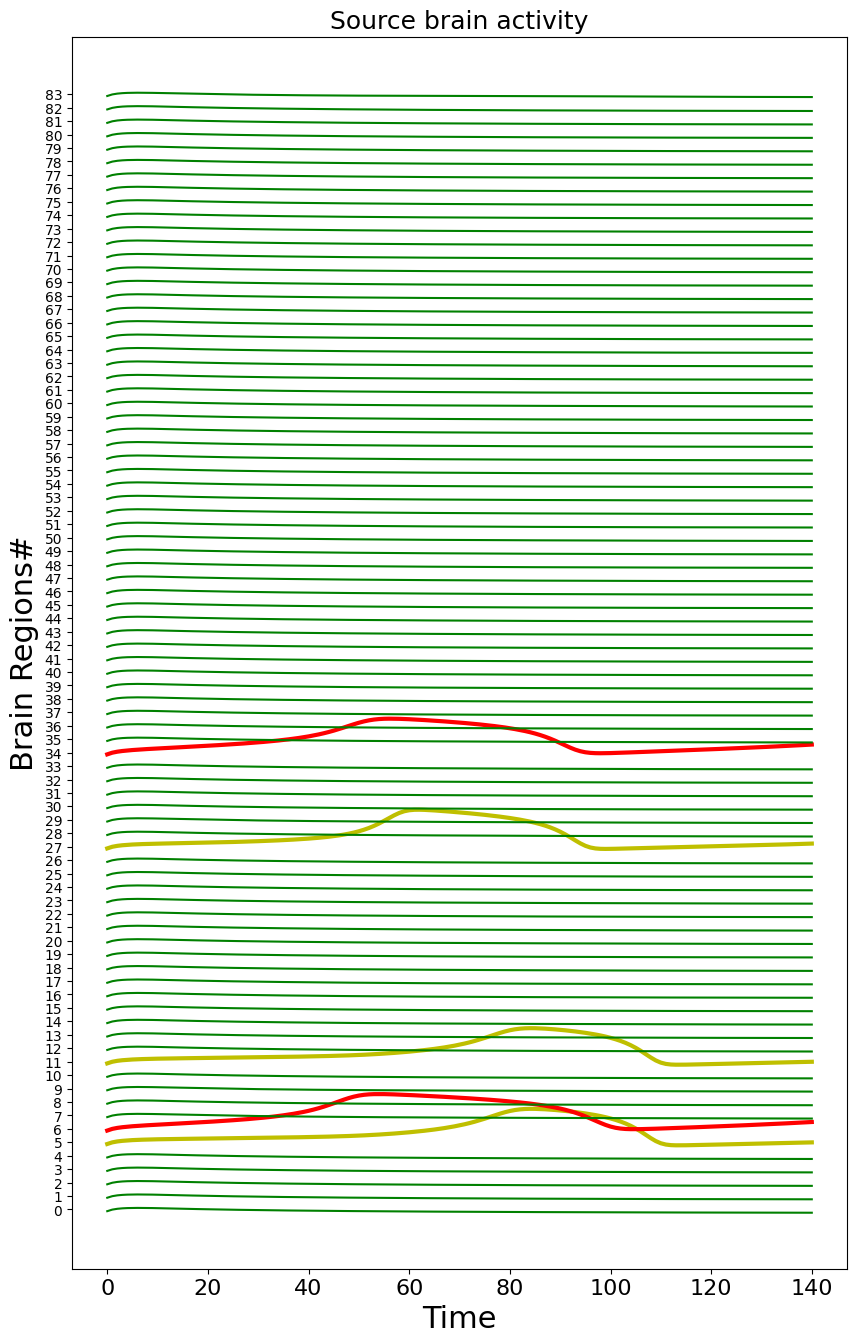

In [ ]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

The lines are the envelopes.

The red lines are the Ez -> -1.6

The yellow lines are Pz -> -2.0

The green flat lines are the Hz (no envelope)

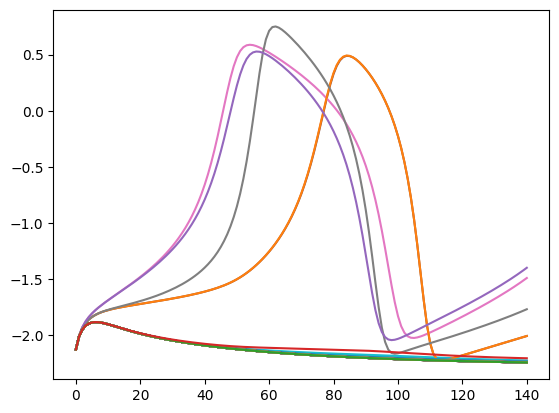

In [ ]:
plt.plot(X.T);

This is a different way of visualization of the above graph.

### Data features

In [ ]:
X.shape

(84, 141)

In [ ]:
X_area = np.trapz(X, dx=0.0001)
X_area.shape

(84,)

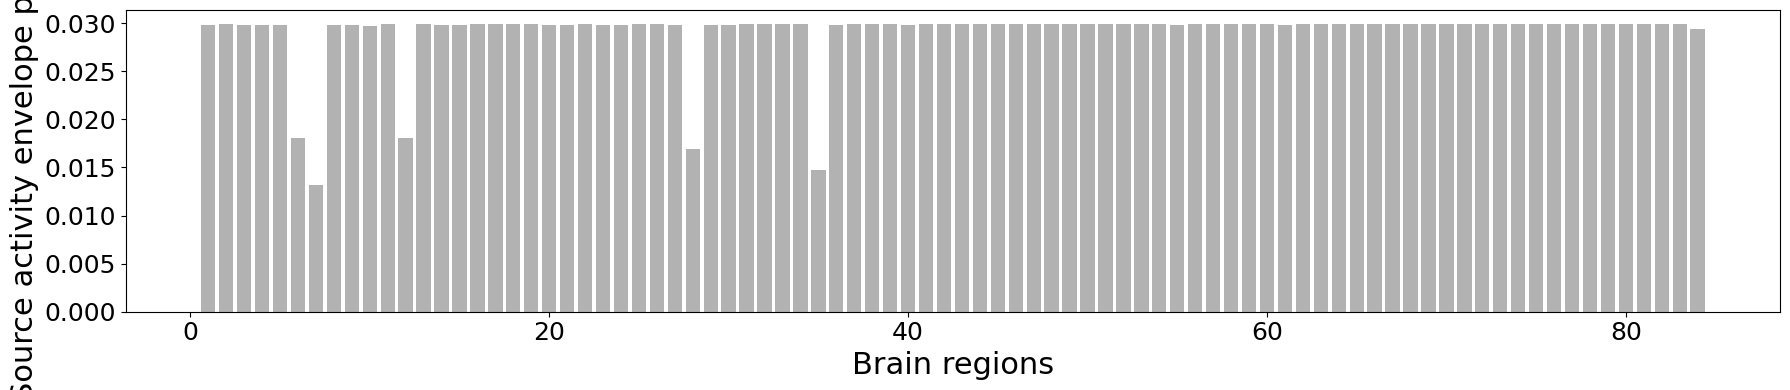

In [ ]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_area.shape[0]+1), -X_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelope power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.svg"), dpi=800)
plt.show()

We use this graph to visualize the data features

Full bars -> Hz

Half bars -> Pz

Small bars -> Ez

In [ ]:
X_pwr = np.sum((X*X), axis=1)
X_pwr_n = 1-(X_pwr/ X_pwr.max())

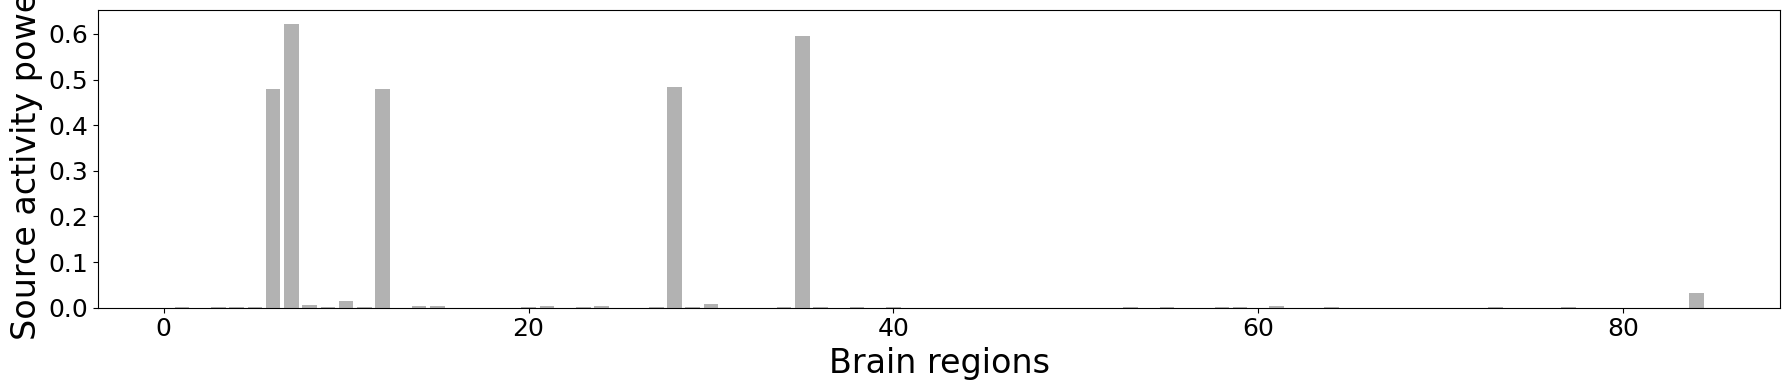

In [ ]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_pwr.shape[0]+1), X_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('Source activity power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.svg"), dpi=800)
plt.show()

This graph is also used to visualize the data features, but in a different method.

Hz are the zero.

Ez are the maximum.

Pz are the small bars.

This visualization is easier to understand, so we abide by it for the rest of the notebook.

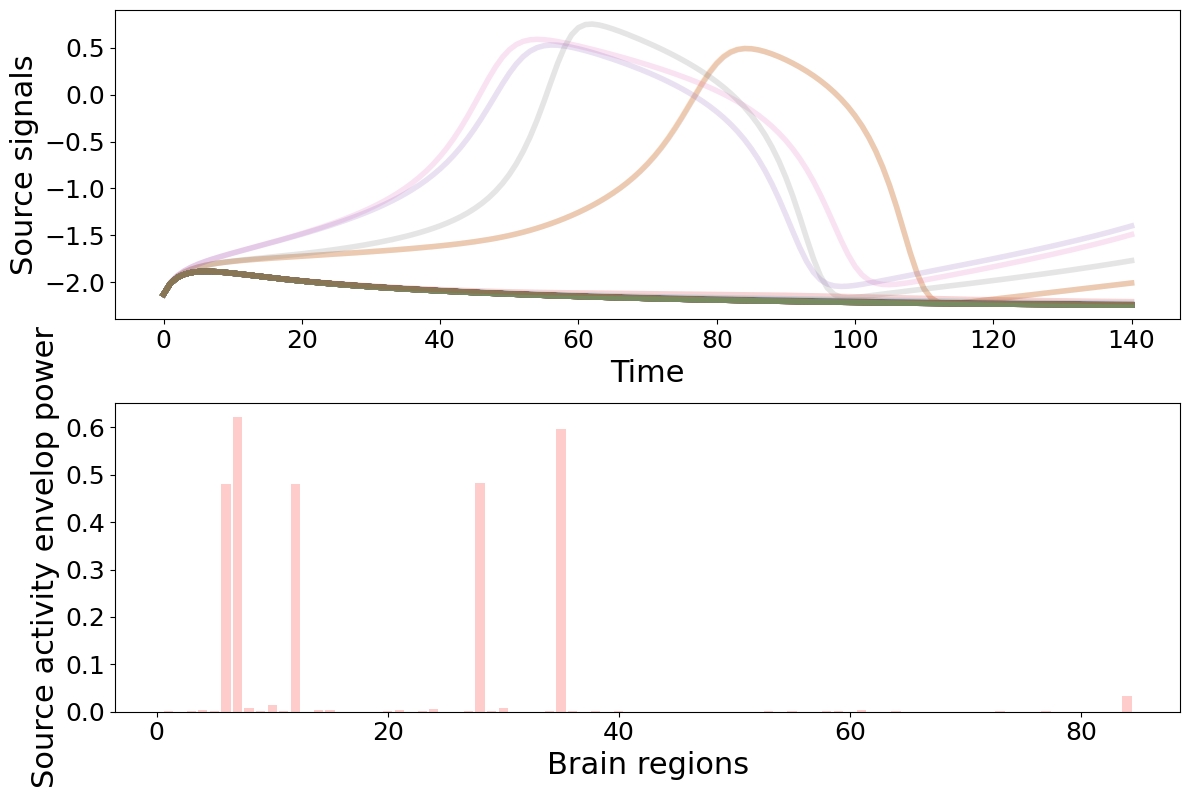

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(X.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,X_pwr_n.shape[0]+1), X_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelop power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from BVEP_stat_summary import calculate_summary_statistics_features

In [ ]:
nn, ns, nt

(84, 84, 141)

In [ ]:
_=calculate_summary_statistics_features(X.reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 588


In [ ]:
num_params=2 #k and z

### 1. Simulator wrapper

New simulator wrapper based of the new VEP2DModel to estimate Tau

In [ ]:
def VEP2Dmodel_source_simulator_wrapper(params):
    #Our params will be z and K and we fix eta and tau

    params = np.asarray(params)

    #extracting
    z = float(params[0])
    K = float(params[1])

    # time step
    T = 14.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau=10. #will not be fixed in the second iteration, goal is to find ideal tau
    sigma=0*10e-1
    eta = np.ones(nn)*hz_val
    eta[ez_idx] = ez_val
    eta[pz_idx] = pz_val
    eta = np.asarray(eta, dtype=np.float64)
    sigma=0*10e-1
    constants = (eta[0:nn], sigma) #tuple because of different types

    nn=SC.shape[0]
    ns=nn
    nt=ts.shape[0]

    # initial conditions
    x_init=-2.5
    z_init=3.5
    init_conditions = np.array([x_init, z_init])

    Sim = VEP2Dmodel(params, constants, init_conditions, dt, ts, SC)

    return Sim


### 2. Prior over model parameters

In [ ]:
prior_min_z=3.5*np.ones(nn)
prior_max_z=5*np.ones(1)

prior_min_K= 0*np.ones(1)
prior_max_K= 2*np.ones(1)

In [ ]:
prior_min=np.append(prior_min_z, prior_min_K)
prior_max=np.append(prior_max_z, prior_max_K)

In [ ]:
prior_min.shape, prior_max.shape

((85,), (2,))

In [ ]:
prior = BoxUniform(low=torch.tensor(prior_min),
                  high=torch.tensor(prior_max))

RuntimeError: The size of tensor a (85) must match the size of tensor b (2) at non-singleton dimension 0

In [ ]:
prior.sample().shape, prior.batch_shape, prior.event_shape

### 3. Simulation and inference

In [ ]:
num_sim=1000
#Potential to explore: increase the number of simulator for tau like from 100 to 1000 for 2 parameters

In [ ]:
mysavepath = '/content/BVEP/SBI/results/simulated_theta_x.npz'
mysavepath

In [ ]:
def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):
    # Sample parameters from prior
    theta = prior.sample((num_simulations,))
    #In Bayesian inference, theta is the vector of parameters you want to infer or simulate from.

    all_sims = []
    for params in theta:
        sim_result = simulator(params)
        all_sims.append(sim_result)

    all_sims = np.array(all_sims)

    print('theta shape:', theta.shape)  # (num_simulations, 2)
    print('data shape:', all_sims.shape)  # (num_simulations, sim_length) or (num_simulations, ...)

    np.savez(mysavepath, theta=theta, x=all_sims)

In [ ]:
import time

start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print("-" * 60)
print(f"--- one sim took: {time.time() - start_time} seconds ---")

In [ ]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim with JIT took: %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

### Load simulations and calculate features

In [ ]:
sim_deja=np.load(mysavepath)
print(sim_deja)

In [ ]:
z_deja = sim_deja['theta']  #In Bayesian inference, theta is the vector of parameters you want to infer or simulate from.
x_deja = sim_deja['x']

In [ ]:
print( 'tau shape:',z_deja.shape,flush=True)
print('data shape:', x_deja.shape,flush=True)

In [ ]:
z_deja_features = np.zeros((num_sim, num_params))
x_deja_features = np.zeros((num_sim, num_features))

In [ ]:
print( 'tau shape:',z_deja_features.shape,flush=True)
print('data frature shape:', x_deja_features.shape,flush=True)

In [ ]:
start_time = time.time()

for i in range(num_sim):
    z_deja_features[i, :] = z_deja[i, :]
    x_deja_features[i, :] = calculate_summary_statistics_features(
        x_deja[i, :].reshape(-1), nn, nt, dt, ts, features=['seizures_onset']
    )
print("-" * 60)
print(f"--- feature calculation took: {time.time() - start_time} seconds ---")

In [ ]:
print( 'z deja shape:', z_deja_features.shape,flush=True)
print('data deja feature shape:', x_deja_features.shape,flush=True)

In [ ]:
np.isnan(np.sum(x_deja_features))

In [ ]:
x = np.array(x_deja_features, dtype='float32')
x = torch.as_tensor(x)
z_infer = np.array(z_deja_features, dtype='float32')
z_infer = z.reshape(z_infer.shape[0],num_params)
z_infer = torch.as_tensor(z_infer)

In [ ]:
print( 'z shape:',z_infer.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

### Inference

In [ ]:
def myinfer_SNPE(prior, z_infer, x):
    inference = SNPE(prior, density_estimator='maf')
    _ = inference.append_simulations(z_infer, x).train()
    posterior = inference.build_posterior(sample_with='direct')
    #To do direct sampling from the posterior with sbi above v0.23.0, you have to use `sample_with='direct'
    return posterior


In [ ]:
start_time = time.time()

posterior = myinfer_SNPE(prior, z_infer, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

### Data

In [ ]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

In [ ]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [ ]:
obs_source.shape, obs_summary_statistics.shape

In [ ]:
y_obs=obs_source
y_obs.shape

In [ ]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

### Posterior



In [ ]:
from BVEP_SME import SME_labels, SEM_violinplot, true_node_binary, estimated_node_binary, SME_accuracy
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
nodes=np.r_[0:nn] #84 brain regions

In [ ]:
num_samples=200

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

In [ ]:
posterior_samples.shape, params_true.shape

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_posteriorsamples.npy') , posterior_samples)

In [ ]:
z_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [ ]:
K_posterior.mean(), K_posterior.std()

In [ ]:
z_true=3.5 #eta c was -1.95
z_critical = 2.5
delta_z=1.0 #delta tau was 1.0, I persume this must stay

Violinplot for Z

In [ ]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

xqplt.figure(figsize=(15,4))
#Violionplot using only z_true vs z_posterior
plt.violinplot(z_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[0] ,'o', color='k', alpha=0.9, markersize=8)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

Violinplot for K

In [ ]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [ ]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [ ]:
y_fit=yfit_source
y_fit.shape

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_fit.npy') , y_fit)

In [ ]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
z_true.shape, z_posterior.shape

In [ ]:
np.sum(np.std(eta_posterior, axis=0))

In [ ]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [ ]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [ ]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [ ]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

In [ ]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

In [ ]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

Posterior shrinkages = how much from prior you improved your posterio

If your posterir is equal to your prior it means you didn't really mean anything

If there is some leakges then its good. But it should be within the range (concenrtated around the true value) aka prior is from 0 to 5 and prosterior is 6

Posterior shrinage should be between 0 to 1
when it is at 1 it means we learned the maximum value